In [2]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper


In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke('attention is all you need')

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
wiki.invoke('Diet')

c:\Users\ADMIN\Desktop\Langchain_Langraph\.venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\ADMIN\Desktop\Langchain_Langraph\.venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


'Page: National Diet\nSummary: The National Diet (国会, Kokkai; Japanese pronunciation: [kok.kai]) is the national legislature of Japan. It is composed of a lower house, called the House of Representatives (衆議院, Shūgiin), and an upper house, the House of Councillors (参議院, Sangiin). Both houses are directly elected under a parallel voting system. In addition to passing laws, the Diet is formally responsible for nominating the prime minister. The Diet was first established as the Imperial Diet in 1890'

In [10]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv('TAVILY_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()
tavily.invoke('provide me recent ai news')

[{'title': 'The latest AI news we announced in June',
  'url': 'https://blog.google/technology/ai/google-ai-updates-june-2025/',
  'content': '# The latest AI news we announced in June\n\nJul 02, 2025\n\nHere’s a recap of some of our biggest AI updates from June, including more ways to search with AI Mode, a new way to share your NotebookLM notebooks publicly, and a new AI to help researchers better understand the human genome.\n\nSuperG\n\n## Basic explainer [...] a text card reading "AI to revolutionize scientific discovery"\n\nWe introduced AlphaGenome: AI to better understand the human genome. Our new, unifying DNA sequence model advances regulatory variant-effect prediction and promises to shed new light on genome function. To advance scientific research, we’re making AlphaGenome available in preview via our AlphaGenome API for non-commercial research, with plans to release the model in the future. [...] For more than 20 years, we’ve invested in machine learning and AI research, t

In [12]:
tools = [arxiv,wiki,tavily]


In [14]:
from langchain_groq import ChatGroq

model_client = ChatGroq(model='gemma2-9b-it')

model_with_tools = model_client.bind_tools(tools)

In [16]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage
model_with_tools.invoke([HumanMessage(content='what is the recent ai innovation')]).tool_calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent ai innovation'},
  'id': 'ehg9s3vx5',
  'type': 'tool_call'}]

### Entire chatbot with langgraph

In [18]:
from IPython.display import Image
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from typing import TypedDict,Annotated,List
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages 
# State Schema
class state(TypedDict):
    messages:Annotated[List[AnyMessage],add_messages]

def tool_calling_llm(state:state):
    return {'messages':[model_with_tools.invoke(state['messages'])]}


In [19]:
graph = StateGraph(state)
graph.add_node('tool_calling_llm',tool_calling_llm)

graph.add_node('tools',ToolNode(tools))
graph.add_edge(START,'tool_calling_llm')
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge('tools',END)
graph_builder = graph.compile()

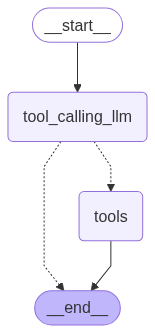

In [21]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [22]:
messages = graph_builder.invoke({'messages':HumanMessage(content='1706.03762')})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (ycwj0we4j)
 Call ID: ycwj0we4j
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


### ReAct : General Agent Architecture

In [45]:
def multiply(a:int,b:int)->int:
    ''' multiplies a and b
        Args: 
        a: first number
        b: Second Number
        return : output'''
    return a * b

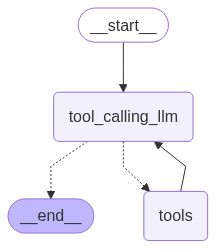

In [46]:
graph = StateGraph(state)
graph.add_node('tool_calling_llm',tool_calling_llm)
tools = [arxiv,wiki,multiply]
graph.add_node('tools',ToolNode(tools))
graph.add_edge(START,'tool_calling_llm')
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge('tools','tool_calling_llm')

graph_builder = graph.compile()
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [48]:
messages = graph_builder.invoke({'messages':HumanMessage(content='what is value of multiplication ')})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is value of multiplication 
================================== Ai Message ==================================
Tool Calls:
  wikipedia (f41v4t7hj)
 Call ID: f41v4t7hj
  Args:
    query: multiplication
================================= Tool Message =================================
Name: wikipedia

Page: Multiplication
Summary: Multiplication is one of the four elementary mathematical operations of arithmetic, with the other ones being addition, subtraction, and division. The result of a multiplication operation is called a product. Multiplication is often denoted by the cross symbol, ×, by the mid-line dot operator, ·, by juxtaposition, or, in programming languages, by an asterisk, *.
The multiplication of whole numbers may be thought of as repeated addition; that is, the multiplication o
================================== Ai Message ==================================

Multiplication is one of the four